## Logistic Regression Implementation on (scaled) Reduced Dataset with PCA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data) and reduced dataset

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [4]:
df_pca = pd.read_csv('../../DimensionalityReductionData/PCA.csv')

In [5]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.073496,0.581127,-0.306591,-0.458056,-0.326569,-0.432148,0.285284,0.120601,-0.382754,-0.220533,-0.173304,-0.237751,-0.278836,-0.255647,-0.126061,-0.138865,0.025244,-0.275903
1,-0.674232,0.297946,0.299652,-0.247368,0.350443,0.430246,-0.511015,0.180800,-0.014047,-0.185657,0.105798,-0.102234,-0.070109,0.002179,0.138295,0.010346,0.088212,0.026563
2,-0.602295,-0.213501,-0.367282,0.446712,-0.379628,0.201488,0.226710,0.332919,-0.030743,-0.052051,0.197735,-0.145173,0.140576,0.062989,-0.117784,0.002612,-0.020744,0.096351
3,-0.308130,-0.303248,-0.099318,-0.550675,0.147219,-0.608601,-0.045995,0.519164,0.094052,-0.122320,0.207885,-0.691366,-0.326278,-0.371787,-0.147163,0.056105,-0.315359,-0.211726
4,-0.548584,-0.107256,0.301375,-0.134301,-0.221954,-0.139591,-0.175504,-0.064892,0.043229,-0.271392,0.054528,-0.095603,-0.064297,0.011336,0.107454,-0.038404,0.111143,0.080739


Keep only the 'averageRating' column and join with PC1,PC2, ... PC18 from PCA (components)

In [6]:
df_scaled_copy = df_scaled[['averageRating']]
df_scaled = df_pca
df_scaled['averageRating'] = df_scaled_copy['averageRating']
del df_scaled_copy

In [7]:
df_scaled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,averageRating
0,0.073496,0.581127,-0.306591,-0.458056,-0.326569,-0.432148,0.285284,0.120601,-0.382754,-0.220533,-0.173304,-0.237751,-0.278836,-0.255647,-0.126061,-0.138865,0.025244,-0.275903,1
1,-0.674232,0.297946,0.299652,-0.247368,0.350443,0.430246,-0.511015,0.180800,-0.014047,-0.185657,0.105798,-0.102234,-0.070109,0.002179,0.138295,0.010346,0.088212,0.026563,0
2,-0.602295,-0.213501,-0.367282,0.446712,-0.379628,0.201488,0.226710,0.332919,-0.030743,-0.052051,0.197735,-0.145173,0.140576,0.062989,-0.117784,0.002612,-0.020744,0.096351,1
3,-0.308130,-0.303248,-0.099318,-0.550675,0.147219,-0.608601,-0.045995,0.519164,0.094052,-0.122320,0.207885,-0.691366,-0.326278,-0.371787,-0.147163,0.056105,-0.315359,-0.211726,0
4,-0.548584,-0.107256,0.301375,-0.134301,-0.221954,-0.139591,-0.175504,-0.064892,0.043229,-0.271392,0.054528,-0.095603,-0.064297,0.011336,0.107454,-0.038404,0.111143,0.080739,0


Take sample for (initial) tests

In [8]:
#df_scaled_sample = df_scaled.sample(n=5000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [9]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [10]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [11]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [12]:
predictions = model.predict(X_test)

Metrics for LR_original:
Accuracy: 0.7255
Weighted F1: 0.7249
Weighted Precision: 0.7259
Weighted Recall: 0.7255
Macro-Averaged Precision: 0.7260
Macro-Averaged Recall: 0.7239
F1: [0.74346202 0.70487106]
Precision: [0.72101449 0.73105498]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.74      1556
     Class 1       0.73      0.68      0.70      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.72      0.72      3002
weighted avg       0.73      0.73      0.72      3002

Confusion Matrix


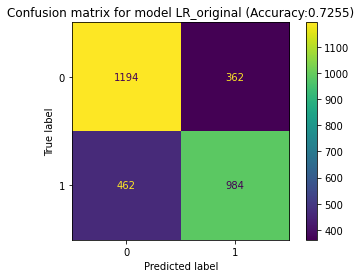

In [13]:
model_metrics = calculate_metrics('LR_original', y_test, predictions)

In [14]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [15]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [16]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7251832111925383


Results of best models Grid Search CV

In [17]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
84   {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'sol...         0.716451
119  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...         0.716451
135  {'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...         0.716451
134  {'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...         0.716451
131  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...         0.716451


Metrics for LR_CV1_best:
Accuracy: 0.7252
Weighted F1: 0.7246
Weighted Precision: 0.7255
Weighted Recall: 0.7252
Macro-Averaged Precision: 0.7256
Macro-Averaged Recall: 0.7236
F1: [0.74291056 0.70483005]
Precision: [0.72111313 0.7301705 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.74      1556
     Class 1       0.73      0.68      0.70      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.72      0.72      3002
weighted avg       0.73      0.73      0.72      3002

Confusion Matrix


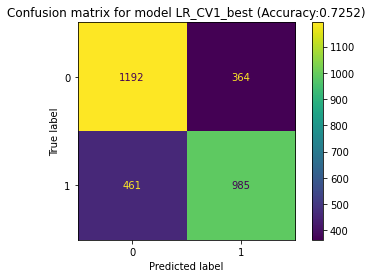

In [18]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [19]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy with Stratified K-Fold: 0.7258494337108594


Results of the best model 

In [20]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7258494337108594


Results of best models Grid Search CV

In [21]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
106  {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 's...         0.716701
86   {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'sol...         0.716701
90   {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'so...         0.716701
94   {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'so...         0.716701
110  {'C': 1, 'max_iter': 5000, 'penalty': 'l2', 's...         0.716701


Metrics for LR_skf_best:
Accuracy: 0.7258
Weighted F1: 0.7252
Weighted Precision: 0.7262
Weighted Recall: 0.7258
Macro-Averaged Precision: 0.7264
Macro-Averaged Recall: 0.7243
F1: [0.74369355 0.70533477]
Precision: [0.72145015 0.73125464]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.74      1556
     Class 1       0.73      0.68      0.71      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.72      0.72      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


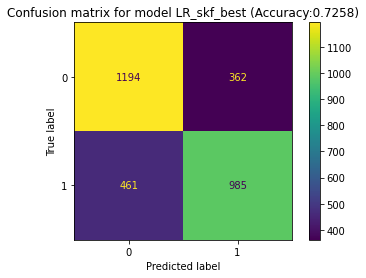

In [22]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [23]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [24]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:23:28,475] A new study created in memory with name: no-name-f9ce98d0-5d95-4407-9ddc-4b678983625a
[I 2024-06-08 00:23:28,563] Trial 0 finished with value: 0.7258494337108594 and parameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.7258494337108594.
[I 2024-06-08 00:23:28,634] Trial 1 finished with value: 0.7255163224516988 and parameters: {'penalty': 'l2', 'C': 0.7147547361025183, 'max_iter': 471, 'solver': 'saga'}. Best is trial 0 with value: 0.7258494337108594.
[I 2024-06-08 00:23:28,665] Trial 2 finished with value: 0.7245169886742172 and parameters: {'penalty': 'l1', 'C': 0.5871453092844537, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7258494337108594.
[I 2024-06-08 00:23:28,695] Trial 3 finished with value: 0.7251832111925383 and parameters: {'penalty': 'l1', 'C': 2.9335873033004263, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7258494337108594.
[

Best Hyperparameters: {'penalty': 'l2', 'C': 0.6556855070061354, 'max_iter': 968, 'solver': 'liblinear'}
Best Accuracy: 0.72618254497002


In [25]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
18,18,0.726183,2024-06-08 00:23:29.498872,2024-06-08 00:23:29.561941,0 days 00:00:00.063069,0.655686,968,l2,liblinear,COMPLETE
153,153,0.726183,2024-06-08 00:23:38.165616,2024-06-08 00:23:38.274627,0 days 00:00:00.109011,1.465852,699,l2,liblinear,COMPLETE
49,49,0.726183,2024-06-08 00:23:31.535738,2024-06-08 00:23:31.598736,0 days 00:00:00.062998,1.407482,848,l2,saga,COMPLETE
31,31,0.726183,2024-06-08 00:23:30.402739,2024-06-08 00:23:30.466774,0 days 00:00:00.064035,0.653523,295,l2,saga,COMPLETE
0,0,0.725849,2024-06-08 00:23:28.478742,2024-06-08 00:23:28.563764,0 days 00:00:00.085022,1.978697,354,l2,saga,COMPLETE
187,187,0.725849,2024-06-08 00:23:41.731653,2024-06-08 00:23:41.843650,0 days 00:00:00.111997,2.128917,641,l2,saga,COMPLETE
162,162,0.725849,2024-06-08 00:23:38.982621,2024-06-08 00:23:39.123583,0 days 00:00:00.140962,2.371988,817,l2,saga,COMPLETE
155,155,0.725849,2024-06-08 00:23:38.334602,2024-06-08 00:23:38.495612,0 days 00:00:00.161010,2.130955,515,l2,saga,COMPLETE
144,144,0.725849,2024-06-08 00:23:37.336138,2024-06-08 00:23:37.407750,0 days 00:00:00.071612,0.558100,987,l2,saga,COMPLETE
134,134,0.725849,2024-06-08 00:23:36.244145,2024-06-08 00:23:36.296150,0 days 00:00:00.052005,0.562679,217,l2,liblinear,COMPLETE


Metrics for LR_OPT1_best:
Accuracy: 0.7262
Weighted F1: 0.7256
Weighted Precision: 0.7265
Weighted Recall: 0.7262
Macro-Averaged Precision: 0.7267
Macro-Averaged Recall: 0.7246
F1: [0.74392523 0.70579814]
Precision: [0.72188634 0.73145401]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.74      1556
     Class 1       0.73      0.68      0.71      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.72      0.72      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


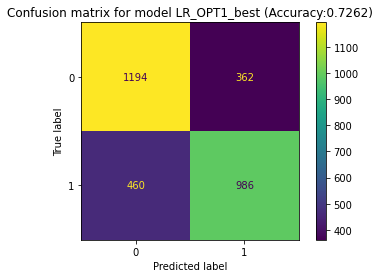

In [26]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT1_best', y_test, predictions_opt1)])

In [27]:
study.best_params

{'penalty': 'l2',
 'C': 0.6556855070061354,
 'max_iter': 968,
 'solver': 'liblinear'}

In [28]:
optuna.visualization.plot_optimization_history(study)

In [29]:
optuna.visualization.plot_parallel_coordinate(study)

In [30]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [33]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [34]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:23:45,105] A new study created in memory with name: no-name-40ea9af9-199f-4f26-8e0a-105659f57631
[I 2024-06-08 00:23:45,208] Trial 0 finished with value: 0.7251832111925383 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7251832111925383.
[I 2024-06-08 00:23:45,297] Trial 1 finished with value: 0.7248500999333778 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7251832111925383.
[I 2024-06-08 00:23:45,384] Trial 2 finished with value: 0.7258494337108594 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 2 with value: 0.7258494337108594.
[I 2024-06-08 00:23:45,477] Trial 3 finished with value: 0.7231845436375749 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.34630026241876444, 'penalty': 'elasticnet', 'C': 0.20813803041222895, 'max_iter': 613, 'solver': 'saga'}
Best Accuracy: 0.7271818787475016


In [35]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
154,154,0.727182,2024-06-08 00:24:00.811928,2024-06-08 00:24:01.006929,0 days 00:00:00.195001,0.208138,0.346300,613,elasticnet,saga,COMPLETE
81,81,0.726849,2024-06-08 00:23:52.430106,2024-06-08 00:23:52.517106,0 days 00:00:00.087000,0.197922,0.302487,898,elasticnet,saga,COMPLETE
172,172,0.726516,2024-06-08 00:24:02.999527,2024-06-08 00:24:03.095563,0 days 00:00:00.096036,0.015190,0.257869,354,elasticnet,saga,COMPLETE
40,40,0.726516,2024-06-08 00:23:48.742085,2024-06-08 00:23:48.828037,0 days 00:00:00.085952,0.465707,0.639390,665,elasticnet,saga,COMPLETE
41,41,0.726516,2024-06-08 00:23:48.829076,2024-06-08 00:23:48.914075,0 days 00:00:00.084999,0.161158,0.396431,458,elasticnet,saga,COMPLETE
146,146,0.726516,2024-06-08 00:23:59.431922,2024-06-08 00:23:59.536925,0 days 00:00:00.105003,0.133622,0.429141,457,elasticnet,saga,COMPLETE
170,170,0.726516,2024-06-08 00:24:02.828529,2024-06-08 00:24:02.910559,0 days 00:00:00.082030,0.290378,0.429591,234,elasticnet,saga,COMPLETE
106,106,0.726516,2024-06-08 00:23:54.637656,2024-06-08 00:23:54.717678,0 days 00:00:00.080022,0.182353,0.388469,475,elasticnet,saga,COMPLETE
129,129,0.726183,2024-06-08 00:23:57.190959,2024-06-08 00:23:57.277957,0 days 00:00:00.086998,0.561933,0.474294,114,elasticnet,saga,COMPLETE
71,71,0.726183,2024-06-08 00:23:51.460792,2024-06-08 00:23:51.552746,0 days 00:00:00.091954,0.453414,0.313701,455,elasticnet,saga,COMPLETE


Metrics for LR_OPT2_best:
Accuracy: 0.7272
Weighted F1: 0.7266
Weighted Precision: 0.7275
Weighted Recall: 0.7272
Macro-Averaged Precision: 0.7277
Macro-Averaged Recall: 0.7256
F1: [0.74478031 0.70697674]
Precision: [0.72292801 0.73239437]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.74      1556
     Class 1       0.73      0.68      0.71      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


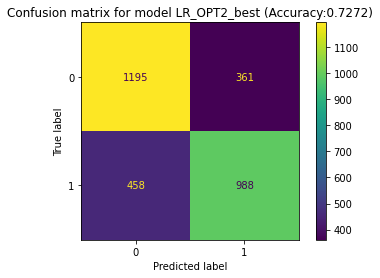

In [36]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT2_best', y_test, predictions_opt2)])

In [37]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [46]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [47]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:26:05,944] A new study created in memory with name: no-name-b01b0e41-2738-41fa-910a-f259ee37c7c3
[I 2024-06-08 00:26:06,079] Trial 0 finished with value: 0.7251832111925383 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7251832111925383.
[I 2024-06-08 00:26:06,204] Trial 1 finished with value: 0.7251832111925383 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.112325872532644, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7251832111925383.
[I 2024-06-08 00:26:06,314] Trial 2 finished with value: 0.7251832111925383 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183841, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7251832111925383.
[I 2024-06-08 00:26:06,426] Trial 3 finished with value: 0.72618254497002 and parameters: {'l1_ratio': 0.41193

Best Hyperparameters: {'l1_ratio': 0.42954226359209646, 'penalty': 'elasticnet', 'C': 0.31783301145958553, 'max_iter': 657, 'solver': 'saga'}
Best Accuracy: 0.7265156562291806


In [40]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
82,82,0.726516,2024-06-08 00:24:16.901390,2024-06-08 00:24:17.019418,0 days 00:00:00.118028,0.317833,0.429542,657,elasticnet,saga,COMPLETE
3,3,0.726183,2024-06-08 00:24:08.644363,2024-06-08 00:24:08.808392,0 days 00:00:00.164029,0.256463,0.411930,896,elasticnet,saga,COMPLETE
126,126,0.725849,2024-06-08 00:24:22.605581,2024-06-08 00:24:22.688221,0 days 00:00:00.082640,1.909984,0.023170,462,elasticnet,saga,COMPLETE
191,191,0.725849,2024-06-08 00:24:29.059943,2024-06-08 00:24:29.153946,0 days 00:00:00.094003,0.652428,0.212852,688,elasticnet,saga,COMPLETE
139,139,0.725849,2024-06-08 00:24:23.761450,2024-06-08 00:24:23.844450,0 days 00:00:00.083000,0.732726,0.314704,267,elasticnet,saga,COMPLETE
173,173,0.725849,2024-06-08 00:24:27.378826,2024-06-08 00:24:27.463860,0 days 00:00:00.085034,0.117680,0.426265,138,elasticnet,saga,COMPLETE
135,135,0.725183,2024-06-08 00:24:23.412457,2024-06-08 00:24:23.498450,0 days 00:00:00.085993,78.172763,0.228233,978,elasticnet,saga,COMPLETE
127,127,0.725183,2024-06-08 00:24:22.689266,2024-06-08 00:24:22.777276,0 days 00:00:00.088010,26.262630,0.535513,567,elasticnet,saga,COMPLETE
128,128,0.725183,2024-06-08 00:24:22.778264,2024-06-08 00:24:22.870266,0 days 00:00:00.092002,29.230015,0.477792,465,elasticnet,saga,COMPLETE
129,129,0.725183,2024-06-08 00:24:22.871263,2024-06-08 00:24:22.960230,0 days 00:00:00.088967,43.747745,0.474294,114,elasticnet,saga,COMPLETE


Metrics for LR_OPT3_best:
Accuracy: 0.7265
Weighted F1: 0.7259
Weighted Precision: 0.7268
Weighted Recall: 0.7265
Macro-Averaged Precision: 0.7270
Macro-Averaged Recall: 0.7250
F1: [0.74399751 0.70647122]
Precision: [0.72259237 0.73131014]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.74      1556
     Class 1       0.73      0.68      0.71      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.72      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


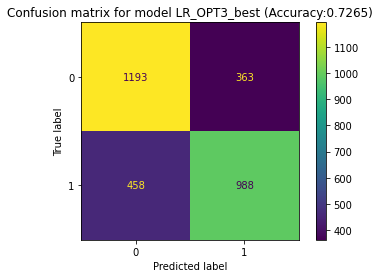

In [41]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT3_best', y_test, predictions_opt3)])

end

In [42]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR_original,0.725516,0.724874,0.725851,0.725516,0.726035,0.723925,[0.74346202 0.70487106],[0.72101449 0.73105498]
LR_CV1_best,0.725183,0.724568,0.725476,0.725183,0.725642,0.723628,[0.74291056 0.70483005],[0.72111313 0.7301705 ]
LR_skf_best,0.725849,0.725217,0.726173,0.725849,0.726352,0.724271,[0.74369355 0.70533477],[0.72145015 0.73125464]
LR_OPT1_best,0.726183,0.725560,0.726495,0.726183,0.726670,0.724617,[0.74392523 0.70579814],[0.72188634 0.73145401]
LR_OPT2_best,0.727182,0.726571,0.727488,0.727182,0.727661,0.725630,[0.74478031 0.70697674],[0.72292801 0.73239437]
LR_OPT3_best,0.726516,0.725922,0.726792,0.726516,0.726951,0.724987,[0.74399751 0.70647122],[0.72259237 0.73131014]
